In [555]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [556]:
def area(x):
    if x == "Los Angeles" or x == "Anaheim" or x == "Long Beach":
        return "Los Angeles"
    elif x == "Dallas" or x == "Arlington" or x == "Fort Worth":
        return "Dallas"
    elif x == "Chicago" or x == "Engin" or x == "Naperville":
        return "Chicago"
    else:
        return "DC"
    
metro = pd.read_csv('../data/final/metro/metro_all.csv')
metro = metro.drop(["Unnamed: 0"], axis = 1)
shuffled = metro.sample(frac=1).reset_index().drop(["index"], axis = 1).drop(["dist_shopping.1"], axis = 1).drop(["Housing Price/SQ Ft"], axis = 1)
shuffled["City"] = shuffled["City"].apply(area)
shuffled = pd.get_dummies(shuffled, columns=["City"])
X = shuffled.drop("Norm Price", 1)
y = shuffled["Norm Price"]
shuffled


/var/folders/cm/_n101lcd24v_khq7567y13rm0000gn/T/ipykernel_12419/2722682471.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = shuffled.drop("Norm Price", 1)


,Norm Price,dist_hospitals,dist_gym,dist_cemetary,dist_parks,dist_beaches,dist_shopping,dist_grocery,dist_resturant,dist_golf,dist_school,City_Chicago,City_DC,City_Dallas,City_Los Angeles
0,0.010432,21448.886744,21453.923786,21412.884227,21460.683755,21410.607298,21452.318217,21452.318217,21453.788477,19601.971426,21451.699031,0,0,0,1
1,0.017299,21489.349148,21494.389966,21453.344889,21501.142247,21451.067806,21492.783611,21492.783611,21494.254815,19642.794028,21492.165553,0,0,0,1
2,0.023442,16381.445433,16384.395775,16365.910508,16378.915438,16309.779700,16382.714182,16382.829556,16385.195499,12177.477853,16381.445433,0,1,0,0
3,0.269873,18013.694329,18302.311501,18307.415176,18305.774965,18248.329678,18296.768784,18227.057350,18300.115860,18264.236833,18294.509960,1,0,0,0
4,0.056683,16379.992858,16382.942828,16364.472395,16377.463499,16308.347327,16381.262614,16381.378006,16383.742652,12183.741508,16379.992858,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3984,0.215489,18023.785423,18312.477463,18317.583107,18315.939558,18258.489751,18306.933923,18237.285727,18310.280992,18274.435777,18304.679110,1,0,0,0
3985,0.489180,18019.382358,18307.920581,18313.022123,18311.385524,18253.945118,18302.378754,18232.597403,18305.725838,18269.809821,18300.115588,1,0,0,0
3986,0.019120,21442.131593,21447.167713,21406.129501,21453.929557,21403.852610,21445.562336,21445.562336,21447.032365,19595.111416,21444.942873,0,0,0,1
3987,0.079952,18318.773898,18314.662358,18309.313050,18310.310090,18319.148460,18311.680404,18311.825665,18303.866278,18309.751994,18303.157208,0,0,1,0


[ 79.88  90.34  98.45 100.01 100.01 100.01 100.01 100.01 100.01 100.01
 100.01 100.01 100.01 100.01]


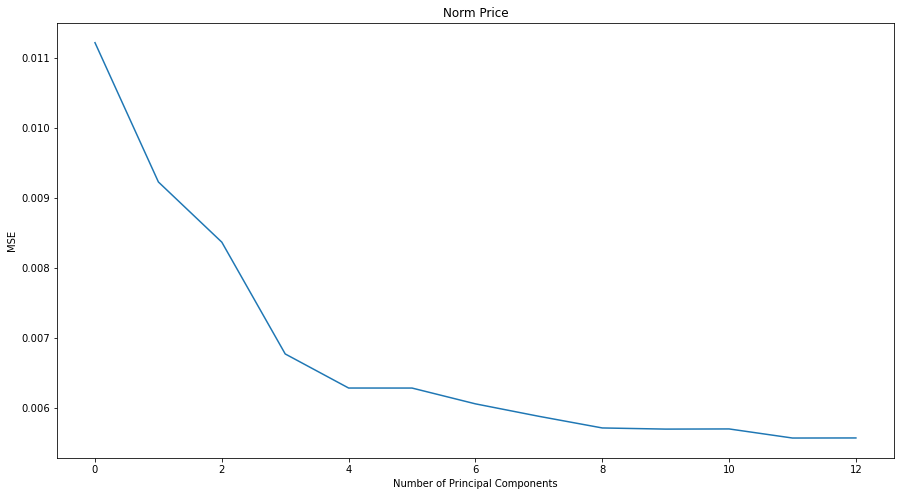

In [558]:
#scale predictor variables
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

#define cross validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept
score = -1*model_selection.cross_val_score(regr,
           np.ones((len(X_reduced),1)), y, cv=cv,
           scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 13):
    score = -1*model_selection.cross_val_score(regr,
               X_reduced[:,:i], y, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot cross-validation results    
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('Norm Price')

print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

rmse = list()
for i in range(1, 13):
    #split the dataset into training (80%) and testing (20%) sets
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0) 

    #scale the training and testing data
    X_reduced_train = pca.fit_transform(scale(X_train))
    X_reduced_test = pca.transform(scale(X_test))[:,:i]

    #train PCR model on training data 
    regr = LinearRegression()
    regr.fit(X_reduced_train[:,:i], y_train)

    #calculate RMSE
    pred = regr.predict(X_reduced_test)
    rmse.append(np.sqrt(mean_squared_error(y_test, pred)))


[0.09136514167727428,
 0.08657847841491548,
 0.07617405033840911,
 0.0735546929120396,
 0.07355440040590075,
 0.4594380274598499,
 0.48278664300259216,
 0.5120026209379643,
 0.4351499914669764,
 1.3956744603239257,
 52.36168650552338,
 87.24562058360472]

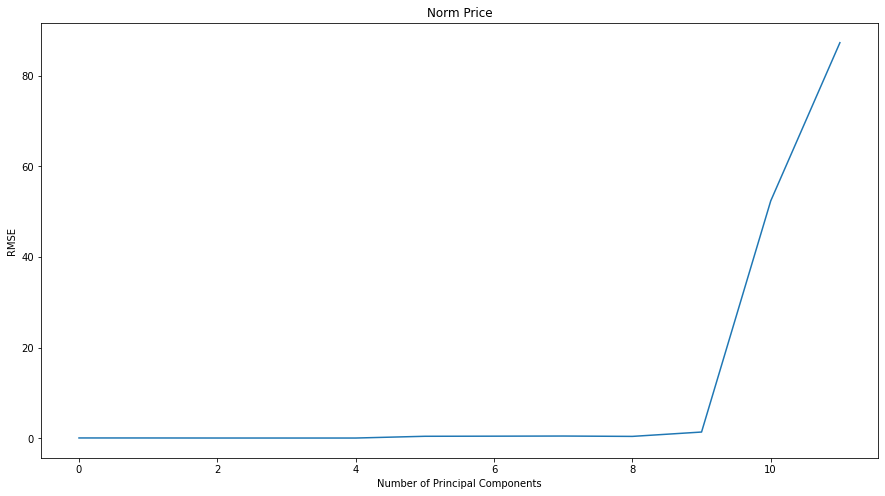

In [560]:
# Plot RMSE results    
plt.plot(rmse)
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('Norm Price')
rmse